# EDA

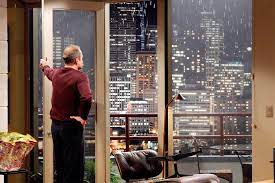

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
from dotenv import load_dotenv

#css
colors = {
    "beige": "#ecc9be",
    "lila": "#b81bc9",
    "orange": "#ff714b",
    "pink": "#ff52ff", 
    "rose" : "#ffd4fd"
}


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (5, 3),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Import Data with psycopg2 and dave as csv in data folder. 

In [2]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

cur = conn.cursor()

query_string = "SELECT * FROM eda.king_county_house_sales"
query_string2 = "SELECT * FROM eda.king_county_house_details"
df_psycopg = pd.read_sql(query_string, conn)
df_psycopg2 = pd.read_sql(query_string2, conn)

conn.close()

df_psycopg.to_csv('data/sales.csv',index=False)
df_psycopg2.to_csv('data/details.csv',index=False)

Understanding Data, what do we have here? 
- make df
- join sets
- check data

In [3]:
df_sales = pd.read_csv("data/sales.csv")
df_details = pd.read_csv("data/details.csv")

df_sales
df_details.head()
df = pd.merge(df_sales, df_details, left_on='house_id', right_on='id', how='outer')
df.drop(columns=["id_x", "id_y"], inplace=True)
# df.info()
# df.describe().T
# df.shape
# df.tail(10)



Observations: 
- data seems to be vollständig (not much nulls), exept years
- column names are correct (small letters and _), i droped doubled columns ids
- Bedrooms between 1 and 33 -> check later!
- größe in sqarefeet -> umrechnen!
- Avg living space fast 200m2 -> evt outlier checken


## Hypothesis

### Client

| Timothy Stevens     | Seller      | Owns expensive houses in the center, needs to get rid, best timing within a year, open for renovation when profits rise       | 
| ------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |                                  

### Question and Hypothesis
| Questions | Hytothesis|
| ------------------- | ----------- |
| When is the best time within the year to sell expensive houses in the city center for the highest possible profit? |  House prices in the city center peak during the spring and summer months due to increased demand.*|
||During holiday seasons (like Thanksgiving or Christmas) Houses sell for lower prices because of reduced buyer activity.*|
||Many houses are sold in March.*|
|||
|||
|How does the potential for renovation impact the selling price for expensive houses in the center?| Renovated houses sell for a significantly higher price compared to similar houses without renovation.*|
|How does the potential for renovation impact the selling time to generate best prices|Houses that need renovation sell better early in the year, not during winter|


'* Hypothesis that needs to be discussed, the rest is optional


## Exploration

- Check distributions of the continuous variables, for example by producing histograms for each of them.
- Check the distributions for the categorical variables, by producing plots/tables of counts.
- Look at the histograms and check for clues or patterns: can you identify groups, are the distributions skewed, do you have extreme values or outliers, where is the data centered. Do you need to remove some data?

## Histograms

All duplicates dropped for visualizing House Data.

In [4]:
# finding duplicates
duplicate_houses = df.groupby('house_id').size() > 1
duplicate_houses = duplicate_houses[duplicate_houses].index
df_duplicates = df[df['house_id'].isin(duplicate_houses)]
#df_duplicates


df_houses_only = df.copy()
df_houses_only = df_houses_only.drop_duplicates(subset='house_id', keep='last')


Text(0.5, 0, 'Number of Bedrooms')

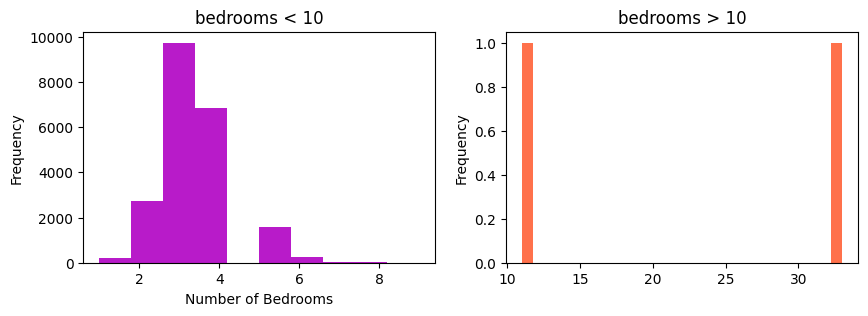

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

df_houses_only[df_houses_only.bedrooms <10].bedrooms.plot(kind="hist",ax=axes[0], color=colors["lila"], title="bedrooms < 10", bins=10)
axes[1].set_xlabel('Number of Bedrooms')
axes[1].set_ylabel('Frequency')

df_houses_only[df_houses_only.bedrooms >10].bedrooms.plot(kind="hist", ax=axes[1], color=colors["orange"], title="bedrooms > 10", bins=30)
axes[0].set_xlabel('Number of Bedrooms')


Text(0.5, 0, 'floors')

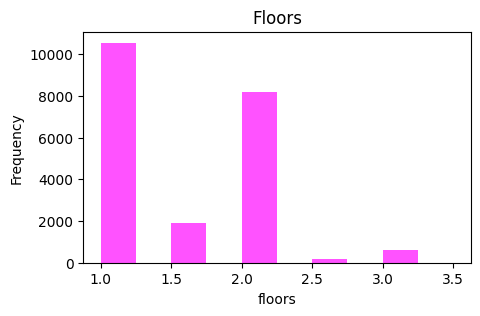

In [6]:

df_houses_only[df_houses_only.floors <10].floors.plot(kind="hist", color=colors["pink"], title="Floors")
plt.xlabel('floors')


Text(0.97, 0.84, '1-3: Falls short of minimum building standards. Normally cabin or inferior structure.\n4:  Generally older, low quality construction. Does not meet code.\n5: Low construction costs and workmanship. Small, simple design.\n6: Lowest grade currently meeting building code. Low quality materials and simple designs.\n7: Average grade of construction and design. Commonly seen in plats and older sub-divisions.\n8: Just above average in construction and design. Usually better materials in both the \n exterior and interior finish work.\n9: Better architectural design with extra interior and exterior design and quality.\n10: Homes of this quality generally have high quality features. Finish work is better and more design quality is \n seen in the floor plans. Generally have a larger square footage.\n11: Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and \n more luxurious options.\n12:  Custom design and excellent builders. All

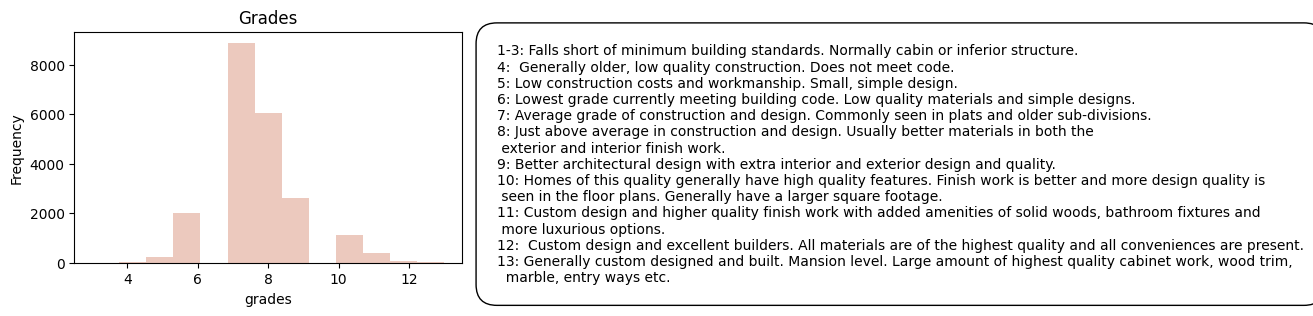

In [7]:
grade_labels={
"1-3": "Falls short of minimum building standards. Normally cabin or inferior structure.",
4:" Generally older, low quality construction. Does not meet code.",
5:"Low construction costs and workmanship. Small, simple design.",
6 :"Lowest grade currently meeting building code. Low quality materials and simple designs.",
7 :"Average grade of construction and design. Commonly seen in plats and older sub-divisions.",
8 :"Just above average in construction and design. Usually better materials in both the \n exterior and interior finish work.",
9 :"Better architectural design with extra interior and exterior design and quality.",
10 :"Homes of this quality generally have high quality features. Finish work is better and more design quality is \n seen in the floor plans. Generally have a larger square footage.",
11 :"Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and \n more luxurious options.",
12:" Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.",
13 :"Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim,\n  marble, entry ways etc.",
}


df_houses_only.grade.plot(kind="hist", color=colors["beige"], title="Grades", bins=13 )
plt.xlabel('grades')

legend_text = "\n".join([f"{k}: {v}" for k, v in grade_labels.items()])

plt.gcf().text(0.97, 0.84, legend_text, fontsize=10, va='top', ha='left', bbox=dict(boxstyle='round,pad=1.5', facecolor='white'))



Text(1, 0.5, ' 1: Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating \n  and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, \n  approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the  \n  end of the scale regardless of the actual chronological age.\n 2: Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, \n deferred maintenance obvious, inadequate building utility and systems all  \n  shortening the life expectancy and increasing the effective age.\n 3: Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor \n repairs are needed, along with some refinishing. All major components still functional and contributing toward \n an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.\n 4: Good- No obvious maintenan

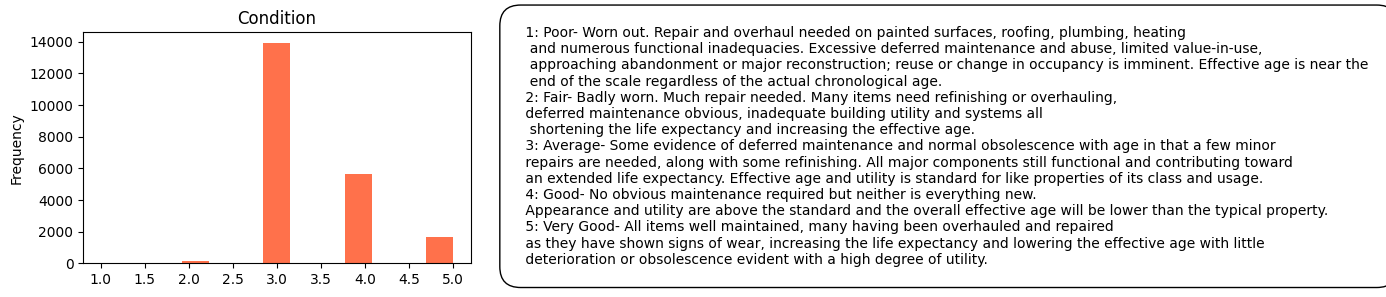

In [8]:
conditions={
1 : "Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating \n  and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, \n  approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the  \n  end of the scale regardless of the actual chronological age.",
2 : "Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, \n deferred maintenance obvious, inadequate building utility and systems all  \n  shortening the life expectancy and increasing the effective age.",
3 : "Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor \n repairs are needed, along with some refinishing. All major components still functional and contributing toward \n an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.",
4 : "Good- No obvious maintenance required but neither is everything new.\n Appearance and utility are above the standard and the overall effective age will be lower than the typical property.",
5: "Very Good- All items well maintained, many having been overhauled and repaired \n as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little \n deterioration or obsolescence evident with a high degree of utility.",
}

df_houses_only.condition.plot(kind="hist", color=colors["orange"], title="Condition", bins=13)

conditions_text = "\n".join([f" {k}: {v}" for k, v in conditions.items()])

plt.gcf().text(1, 0.5, conditions_text, fontsize=10, va='center', ha='left', bbox=dict(boxstyle='round,pad=1.5', facecolor='white'))

## Scatterplots

### pirce of living / lot with sea view

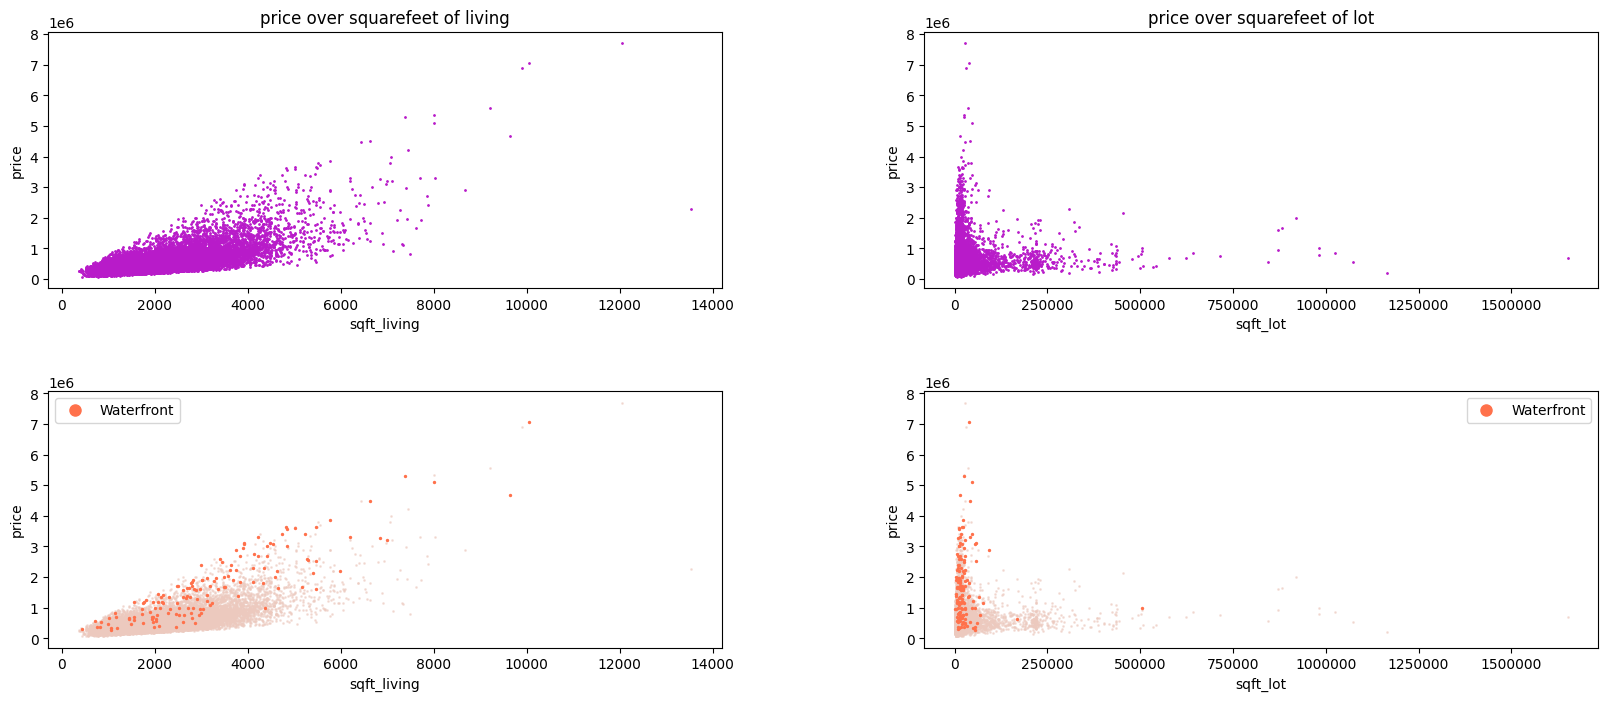

In [24]:
import matplotlib.lines  as mlines  # Für benutzerdefinierte Legenden-Einträge

fig, axes = plt.subplots(2, 2, figsize=(20,8))

df_houses_only.plot(kind="scatter", x='sqft_living', y='price', color=colors["lila"], s = 1, title="price over squarefeet of living", ax=axes[0,0])
df_houses_only.plot(kind="scatter", x='sqft_lot', y='price', color=colors["lila"], s = 1, title="price over squarefeet of lot", ax=axes[0,1])
axes[0,1].ticklabel_format(style='plain', axis='x')
axes[1,1].ticklabel_format(style='plain', axis='x')

df_waterfront = df_houses_only[(df_houses_only['waterfront'] != 0) & (df_houses_only['waterfront'].notna())]
df_no_waterfront = df_houses_only[(df_houses_only['waterfront'] == 0)|(df_houses_only['waterfront'].isna())]

df_no_waterfront.plot(kind="scatter", x='sqft_living', y='price', color=colors["beige"],alpha=0.5, s = 1,  ax=axes[1,0])
df_waterfront.plot(kind="scatter", x='sqft_living', y='price', color=colors["orange"], s = 2,  ax=axes[1,0])

df_no_waterfront.plot(kind="scatter", x='sqft_lot', y='price', color=colors["beige"],alpha=0.5, s = 1, ax=axes[1,1])
df_waterfront.plot(kind="scatter", x='sqft_lot', y='price', color=colors["orange"], s = 2, ax=axes[1,1])

plt.subplots_adjust(hspace=0.4, wspace=0.3) 
orange_circle = mlines.Line2D([], [], color=colors["orange"], marker='o', linestyle='None', markersize=8, label='Waterfront')
axes[1, 0].legend(handles=[orange_circle])
axes[1, 1].legend(handles=[ orange_circle])




Text(78.84722222222221, 0.5, 'Latitude')

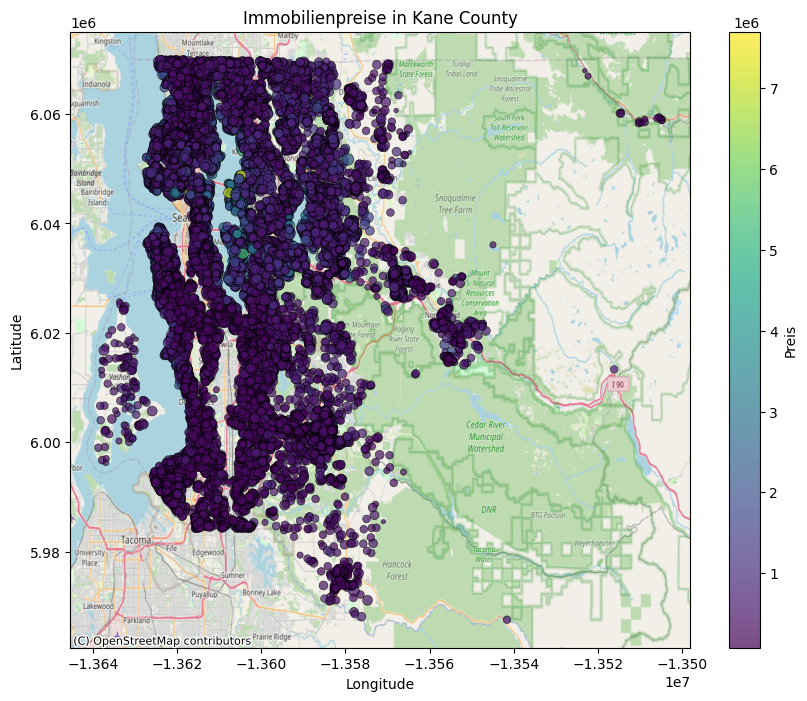

In [25]:
import contextily as ctx
from pyproj import Transformer

transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
df_houses_only['x'], df_houses_only['y'] = transformer.transform(df_houses_only['long'].values, df_houses_only['lat'].values)

# Plot erstellen
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_houses_only['x'], df_houses_only['y'], 
    c=df_houses_only['price'], 
    cmap='viridis', 
    alpha=0.7, 
    s=df_houses_only['bedrooms'] * 10,  # Größere Punkte für mehr Schlafzimmer
    edgecolor='k', 
    linewidth=0.5
)

# Basemap hinzufügen
ctx.add_basemap(plt.gca(), source=ctx.providers.OpenStreetMap.Mapnik)

# Farblegende und Titel
plt.colorbar(scatter, label='Preis')
plt.title('Immobilienpreise in Kane County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


In [26]:
median_prices = df_houses_only.groupby('zipcode')['price'].median().reset_index().sort_values('price')
most_expensive_10_areas = median_prices.tail(10)
cheapest_10_areas = median_prices.head(10)
# Darstellung schwierig, erstmal weglassen


## Conclusion

- the houese with > 30 bedrooms can be droped
- waterfront lots are smaller, but the living area is equally distributed
- condition and grades are avarage and a little bit above average
- houses have mostly one or 2 floors, with about 3-4 bedrooms

## Data Cleaning
Year renovated is in  20130.000 wired shape. 
- Cut the float and one 0 at the end to get a year. Only if len > 4 
- drop all entries that are not a valid year number, make them to 0

In [27]:

df["yr_renovated"] = df['yr_renovated'].fillna(0).astype(int)
df["yr_renovated"] = df["yr_renovated"].astype(str).apply(lambda x: x.rstrip('0') if len(x) > 4 else x)
df["yr_renovated"] = df["yr_renovated"].replace('', '0').astype(int)

# make all entries len < 4 to 0
df.loc[(df['yr_renovated'] != 0) & (df['yr_renovated'].notna()) & 
       (df['yr_renovated'].astype(str).apply(lambda x: len(x) < 4)), 'yr_renovated'] = 0

#655 entries for renovation
df["yr_renovated"][df["yr_renovated"].astype(str).apply(lambda x: len(x) == 4)].count()

np.int64(655)

- make float to int 

In [28]:
df.bedrooms = df.bedrooms.astype(int)
df.floors = df.floors.astype(int)
df.bathrooms = df.bathrooms.astype(int)
df.sqft_lot = df.sqft_lot.astype(int)
df.sqft_living = df.sqft_living.astype(int)


## City Center

<img src="seatle_zip_codes.png" alt="Seattle Zip Codes" width="400" height="300"/>

Green: downtoen Seatle

Orange: center area Seatle

In [29]:
## City Center
downtown_seattle = [98121, 98101, 98104]
center_area_seattle = [98121, 98101, 98104, 98134,98144, 98122,98112,98102, 98109, 98119]

The only zipcodes with listed houses: 98144, 98122,98112,98102, 98109, 98119

In [30]:

df_downtown = df[df['zipcode'].isin(downtown_seattle)] # no entry!!
df_center_area = df[df['zipcode'].isin(center_area_seattle)]


# Hypothesis 1
## House prices in the city center peak during the spring and summer months due to increased demand.*

- City Center is defined as zipcodes in df_center_area
- Not true, Pirces peak in Dezember as well
- (Schaune ob es da outlier gibt)
- (Durchschnittspreise / Median ausrechnen und sortieren)
- (geomap erstellen von betreffenden häusern)

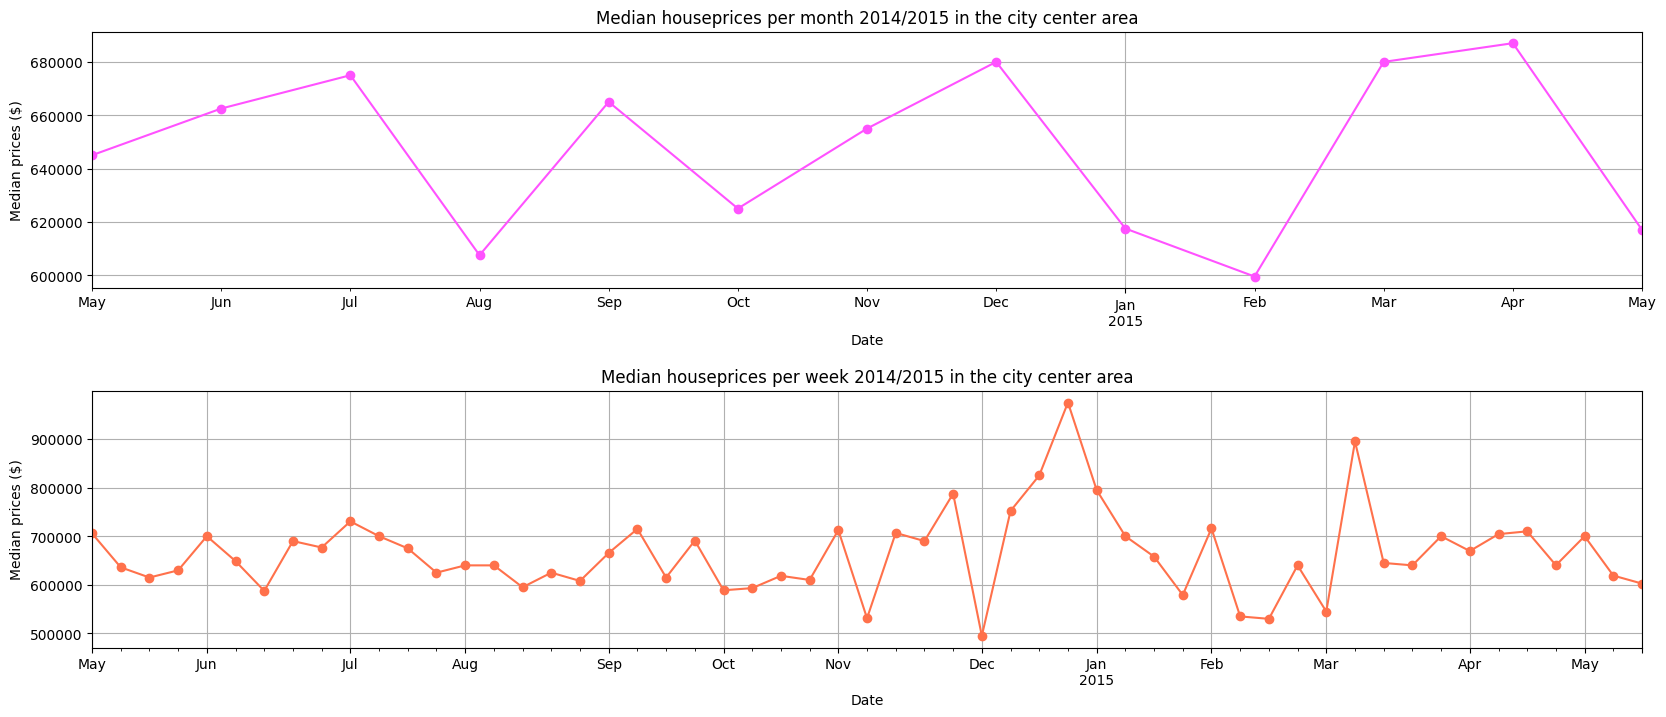

In [39]:
import matplotlib.pyplot as plt

df_center_area['date'] = pd.to_datetime(df_center_area['date'])

# drop outlier, weil zu große Villa, verfälscht den Schnitt
# df_center_area.drop(df_center_area[df_center_area['house_id'] == 6762700020].index, inplace=True)


# find entries for a pecial day in a month
# df_center_area[(df_center_area['date'].dt.month == 10) & (df_center_area['date'].dt.day == 13)].sort_values(by="date")

 
fig, axes = plt.subplots(2,1, figsize=(20, 8))

df_center_area.groupby(df_center_area['date'].dt.to_period('M'))['price'].median().plot(
    kind='line',
    marker='o',
    title='Median houseprices per month 2014/2015 in the city center area',
    xlabel='Date',
    ylabel='Median prices ($)',
    grid=True,
    color=colors["pink"],
    ax=axes[0], 
)

df_center_area.groupby(df_center_area['date'].dt.to_period('w'))['price'].median().plot(
    kind='line',
    marker='o',
    title='Median houseprices per week 2014/2015 in the city center area',
    xlabel='Date',
    ylabel='Median prices ($)',
    grid=True,
    color=colors["orange"],
    ax=axes[1], 
)

plt.subplots_adjust(hspace=0.4, wspace=0.3) 




# Hypothesis 2
## During holiday seasons (like Thanksgiving or Christmas) Houses sell for lower prices because of reduced buyer activity.

> In the United States, the holiday season "is generally considered to begin with the day after Halloween and end after New Year's Day" (Wikipedia)

> The holiday season in the United States begins after Thanksgiving and lasts until New Year's Day. (google KI)

For this calculations: 22.November till 01.01.

- seems to be true 
- price for houses seems to be less Nov - Februar
- exception is the week between chistman and newyear 

FOR OVERALL 

**but that does not seem to be true for city center** ( see last charts)

- (dayli look for holliday season)
- (oeverall und center mal übereinanderlegen)

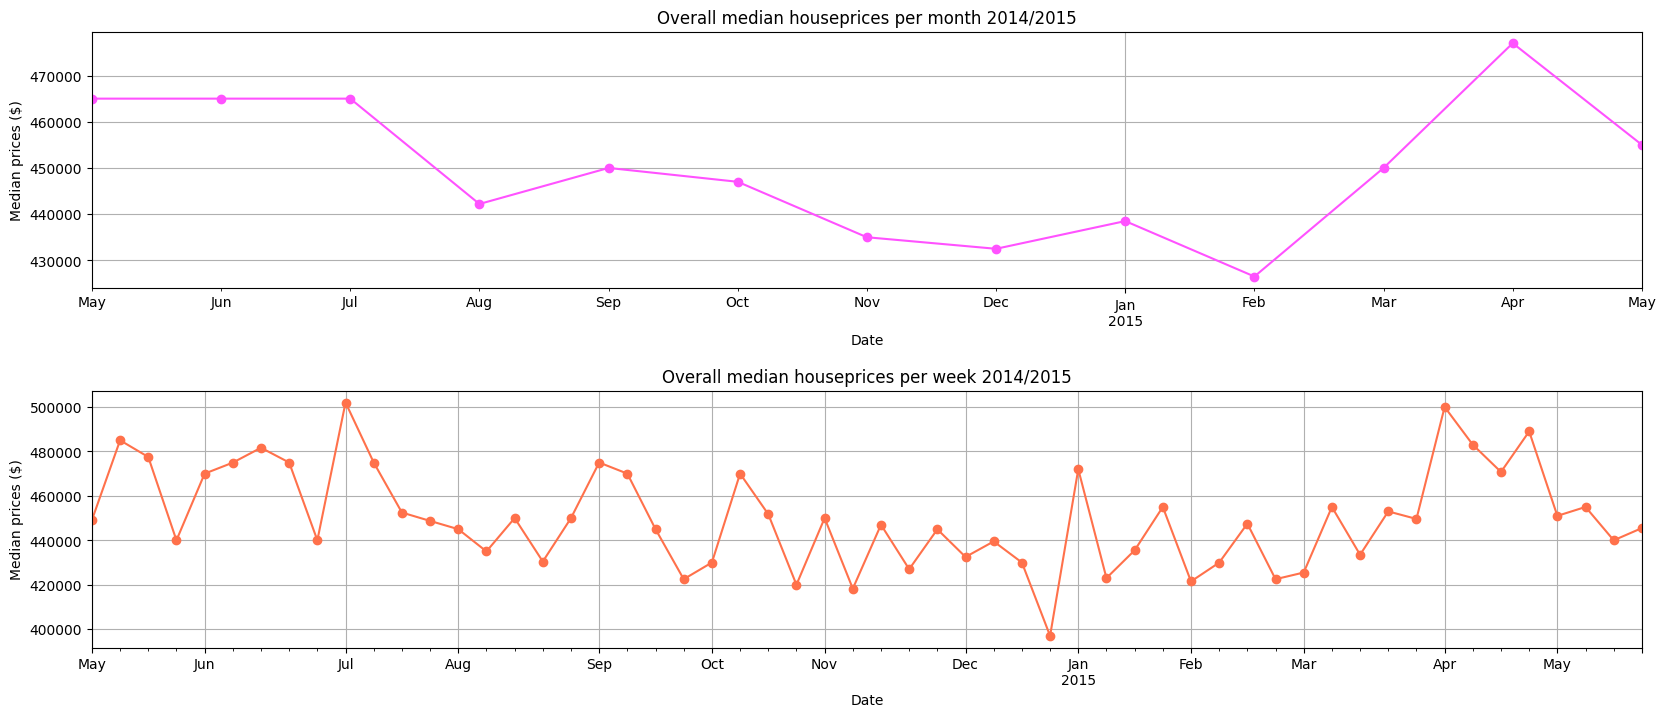

In [43]:
# drop outlier (3 Stück Ende Mai 2015)

# df[(df['date'].dt.month == 5) & (df['date'].dt.day == 29)].sort_values(by="date")
# df.drop(df[df['house_id'] == 9106000005].index, inplace=True)
df['date'] = pd.to_datetime(df['date'])


fig, axes = plt.subplots(2,1, figsize=(20, 8))

df.groupby(df['date'].dt.to_period('M'))['price'].median().plot(
    kind='line',
    marker='o',
    title='Overall median houseprices per month 2014/2015',
    xlabel='Date',
    ylabel='Median prices ($)',
    grid=True,
    ax=axes[0],
    color=colors["pink"]
    
)

df.groupby(df['date'].dt.to_period('w'))['price'].median().plot(
    kind='line',
    marker='o',
    title='Overall median houseprices per week 2014/2015',
    xlabel='Date',
    ylabel='Median prices ($)',
    grid=True,
    ax=axes[1], 
    color=colors["orange"]
    
)

plt.subplots_adjust(hspace=0.4, wspace=0.3) 


# Hypothesis 3
## Many houses are sold in March.

- March is good, but April, June and July is better
- (for expensive houses the same??)

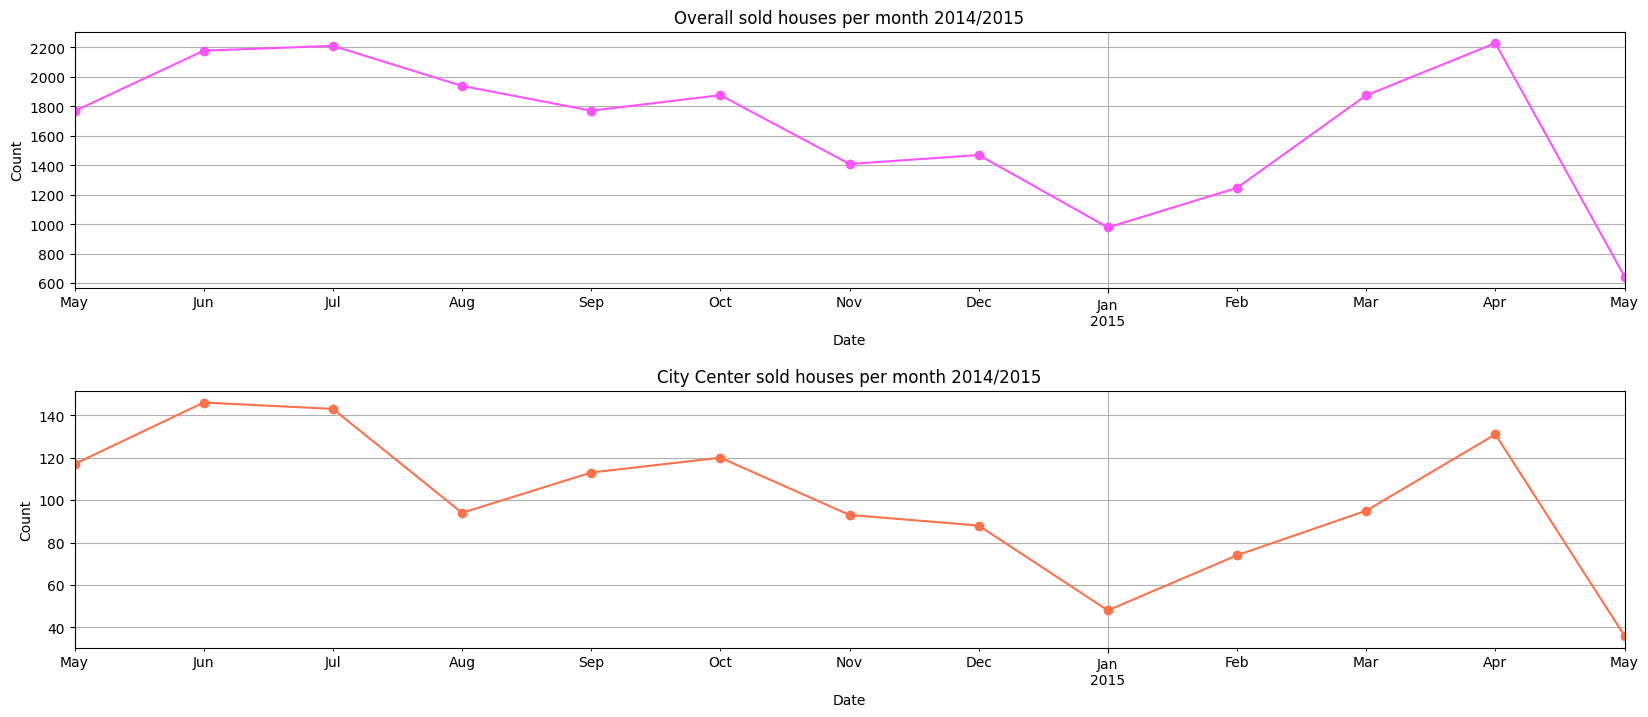

In [44]:
fig, axes = plt.subplots(2,1, figsize=(20, 8))

df.groupby(df['date'].dt.to_period('M'))["date"].count().plot(
    kind='line',
    marker='o',
    title='Overall sold houses per month 2014/2015',
    xlabel='Date',
    ylabel='Count',
    grid=True,
    ax=axes[0],
    color=colors["pink"]
    
)

df_center_area.groupby(df['date'].dt.to_period('M'))["date"].count().plot(
    kind='line',
    marker='o',
    title='City Center sold houses per month 2014/2015',
    xlabel='Date',
    ylabel='Count',
    grid=True,
    ax=axes[1],
    color=colors["orange"]
)

plt.subplots_adjust(hspace=0.4, wspace=0.3) 


# Hypothesis 4
## Renovated houses sell for a significantly higher price compared to similar houses without renovation.

- for sure, average is about 51% more
- for city center area ist 24% more
- for expensive houses in citi center only 2.11%

2.1081991725191145


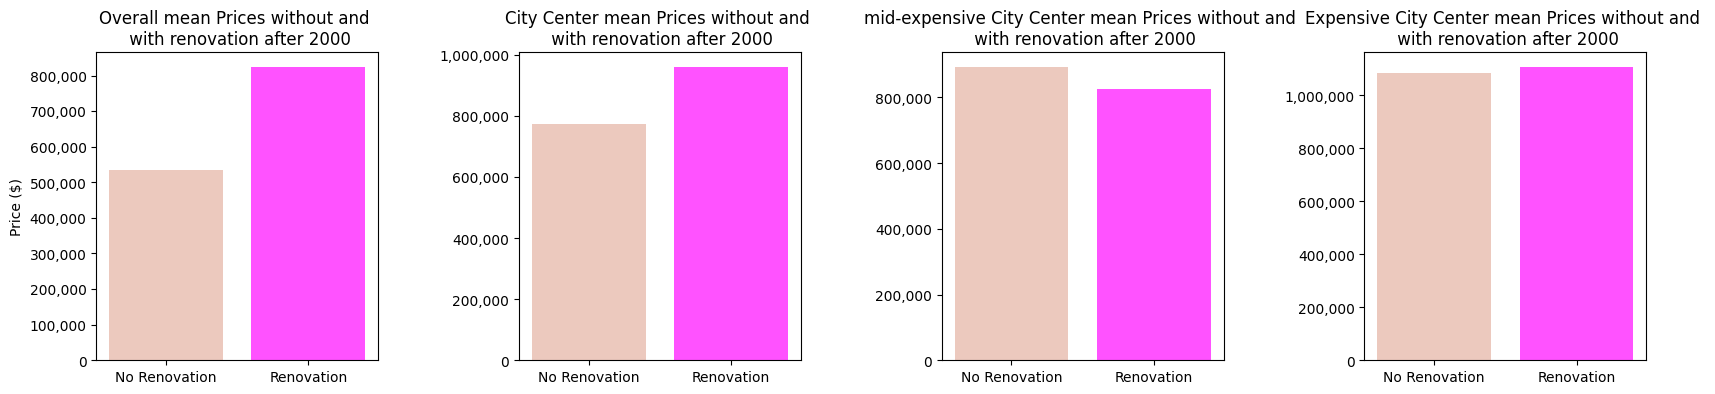

In [116]:
import matplotlib.ticker as mtick

df_renovated_houses = df[(df["yr_renovated"] != 0)]["price"].mean()
df_renovated_houses_after_2000_mean = df[(df["yr_renovated"] > 2000)]["price"].mean()
df_no_renovation_mean =  df[(df["yr_renovated"] == 0)]["price"].mean()

#expensive 
price_threshold = df['price'].quantile(0.75)
expensive_houses_in_center_area = df_center_area[df_center_area["price"]>price_threshold]

renovated_expensive_houses_in_center_area = expensive_houses_in_center_area[(expensive_houses_in_center_area["yr_renovated"]>2000)|(expensive_houses_in_center_area["yr_built"]>2000)]
not_renovated_expensive_houses_in_center_area = expensive_houses_in_center_area[(expensive_houses_in_center_area["yr_renovated"]==0) | (expensive_houses_in_center_area["yr_renovated"]<2000) & (expensive_houses_in_center_area["yr_built"]<2000)]

renovated_expensive_houses_in_center_area_mean=renovated_expensive_houses_in_center_area["price"].mean()
not_renovated_expensive_houses_in_center_area_mean = not_renovated_expensive_houses_in_center_area["price"].mean()

#mid-expensive 
price_threshold = df['price'].quantile(0.50)
mid_expensive_houses_in_center_area = df_center_area[df_center_area["price"]>price_threshold]

renovated_mid_expensive_houses_in_center_area = mid_expensive_houses_in_center_area[(mid_expensive_houses_in_center_area["yr_renovated"]>2000)|(mid_expensive_houses_in_center_area["yr_built"]>2000)]
not_renovated_mid_expensive_houses_in_center_area = mid_expensive_houses_in_center_area[(mid_expensive_houses_in_center_area["yr_renovated"]==0) | (mid_expensive_houses_in_center_area["yr_renovated"]<2000) & (mid_expensive_houses_in_center_area["yr_built"]<2000)]

renovated_mid_expensive_houses_in_center_area_mean=renovated_mid_expensive_houses_in_center_area["price"].mean()
not_renovated_mid_expensive_houses_in_center_area_mean = not_renovated_mid_expensive_houses_in_center_area["price"].mean()

####
df_renovated_houses_city = df_center_area[(df_center_area["yr_renovated"] != 0)]["price"].mean()
df_renovated_houses_after_2000_mean_city = df_center_area[(df_center_area["yr_renovated"] > 2000)]["price"].mean()
df_no_renovation_mean_city =  df_center_area[(df_center_area["yr_renovated"] == 0)]["price"].mean()

categories = ['No Renovation', 'Renovation']
values = [df_no_renovation_mean, df_renovated_houses_after_2000_mean]
values_city = [df_no_renovation_mean_city, df_renovated_houses_after_2000_mean_city]
values_expensive_city = [not_renovated_expensive_houses_in_center_area_mean, renovated_expensive_houses_in_center_area_mean]
values_mid_expensive_city = [not_renovated_mid_expensive_houses_in_center_area_mean, renovated_mid_expensive_houses_in_center_area_mean]

fig, axes = plt.subplots(1,4, figsize=(20, 4))
axes[0].bar(categories, values, color=[colors["beige"], colors["pink"]])
axes[1].bar(categories, values_city, color=[colors["beige"], colors["pink"]])
axes[3].bar(categories, values_expensive_city, color=[colors["beige"], colors["pink"]])
axes[2].bar(categories, values_mid_expensive_city, color=[colors["beige"], colors["pink"]])
axes[0].set_title('Overall mean Prices without and \n with renovation after 2000')
axes[1].set_title('City Center mean Prices without and \n with renovation after 2000')
axes[3].set_title('Expensive City Center mean Prices without and \n with renovation after 2000')
axes[2].set_title('mid-expensive City Center mean Prices without and \n with renovation after 2000')
axes[0].set_ylabel('Price ($)')

formatter = mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')  # Tausendertrennzeichen, keine Nachkommastellen
axes[0].yaxis.set_major_formatter(formatter)
axes[1].yaxis.set_major_formatter(formatter)
axes[2].yaxis.set_major_formatter(formatter)
axes[3].yaxis.set_major_formatter(formatter)


plt.subplots_adjust(wspace=0.5) 


diff = df_renovated_houses_after_2000_mean - df_no_renovation_mean
percentage_increase_by_renovation = (diff/df_no_renovation_mean)*100
percentage_increase_by_renovation

diff_city = df_renovated_houses_after_2000_mean_city - df_no_renovation_mean_city
percentage_increase_by_renovation_city = (diff_city/df_no_renovation_mean_city)*100
percentage_increase_by_renovation_city

diff_city = renovated_expensive_houses_in_center_area_mean - not_renovated_expensive_houses_in_center_area_mean
percentage_increase_by_renovation_city = (diff_city/not_renovated_expensive_houses_in_center_area_mean)*100
percentage_increase_by_renovation_city
print(percentage_increase_by_renovation_city)

# Plot City Center



Text(0.5, 1.0, 'Price map of city center')

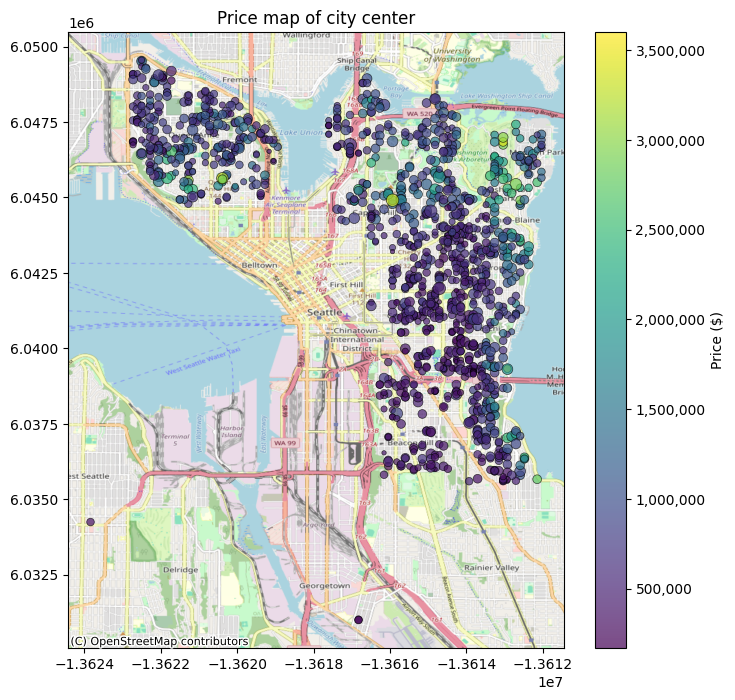

In [47]:
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
df_center_area['x'], df_center_area['y'] = transformer.transform(df_center_area['long'].values, df_center_area['lat'].values)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    df_center_area['x'], df_center_area['y'], 
    c=df_center_area['price'], 
    cmap='viridis', 
    alpha=0.7, 
    s=df_center_area['bedrooms'] * 10,  # Größere Punkte für mehr Schlafzimmer
    edgecolor='k', 
    linewidth=0.5
)

# Basemap hinzufügen
ctx.add_basemap(plt.gca(), source=ctx.providers.OpenStreetMap.Mapnik)


# Farblegende und Titel
cbar = plt.colorbar(scatter, label='Price ($)')
cbar.formatter = mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')  # Preise ausgeschrieben
cbar.update_ticks()
plt.title('Price map of city center')


# renovation investigation

Text(0.5, 1.0, 'Price map of city center, 25% most expensive houses')

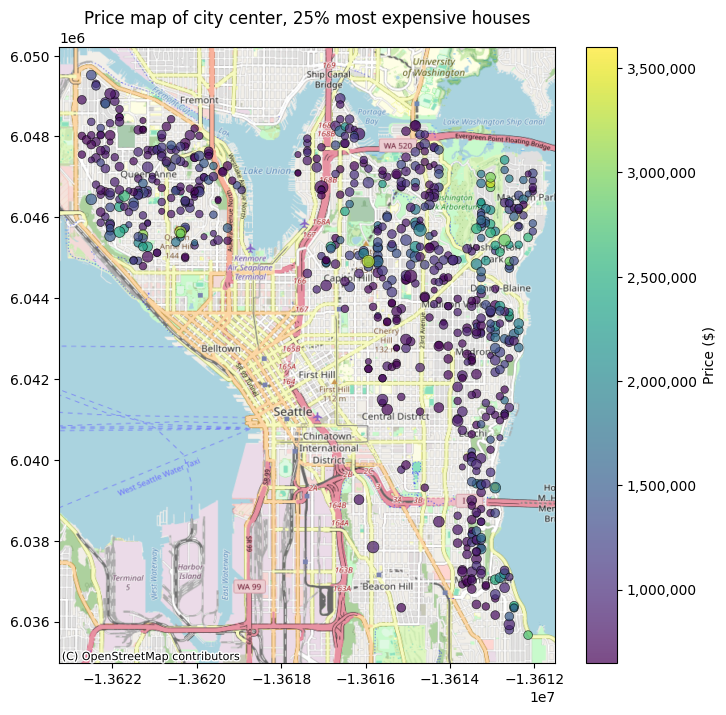

In [119]:
price_threshold = df['price'].quantile(0.75)
expensive_houses_in_center_area = df_center_area[df_center_area["price"]>price_threshold]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    expensive_houses_in_center_area['x'], expensive_houses_in_center_area['y'], 
    c=expensive_houses_in_center_area['price'], 
    cmap='viridis', 
    alpha=0.7, 
    s=expensive_houses_in_center_area['bedrooms'] * 10,  # Größere Punkte für mehr Schlafzimmer
    edgecolor='k', 
    linewidth=0.5
)

# Basemap hinzufügen
ctx.add_basemap(plt.gca(), source=ctx.providers.OpenStreetMap.Mapnik)


# Farblegende und Titel
cbar = plt.colorbar(scatter, label='Price ($)')
cbar.formatter = mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')  # Preise ausgeschrieben
cbar.update_ticks()
plt.title('Price map of city center, 25% most expensive houses')


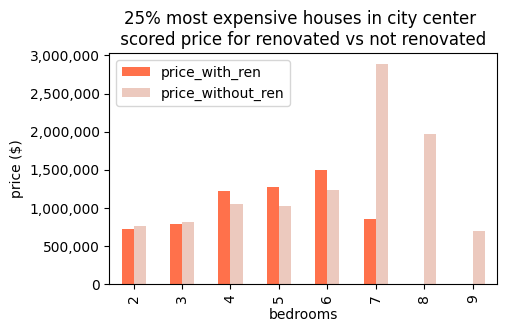

In [101]:

#renovated_expensive_houses_in_center_area.groupby("bedrooms")['price'].mean().plot(kind="bar", x="bedrooms", y="prices")
#not_renovated_expensive_houses_in_center_area.groupby("bedrooms")['price'].mean().plot(kind="bar", x="bedrooms", y="prices")

renovation_df = pd.merge( renovated_expensive_houses_in_center_area.groupby("bedrooms")['price'].median().reset_index(), not_renovated_expensive_houses_in_center_area.groupby("bedrooms")['price'].median().reset_index(), on='bedrooms', how="outer").rename(columns={"price_x":"price_with_ren", "price_y":"price_without_ren"})

ax = renovation_df.set_index("bedrooms")[["price_with_ren", "price_without_ren"]].plot(kind="bar", color=[colors["orange"], colors["beige"]])
plt.ylabel('price ($)')
plt.title('25% most expensive houses in city center \n scored price for renovated vs not renovated ')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))


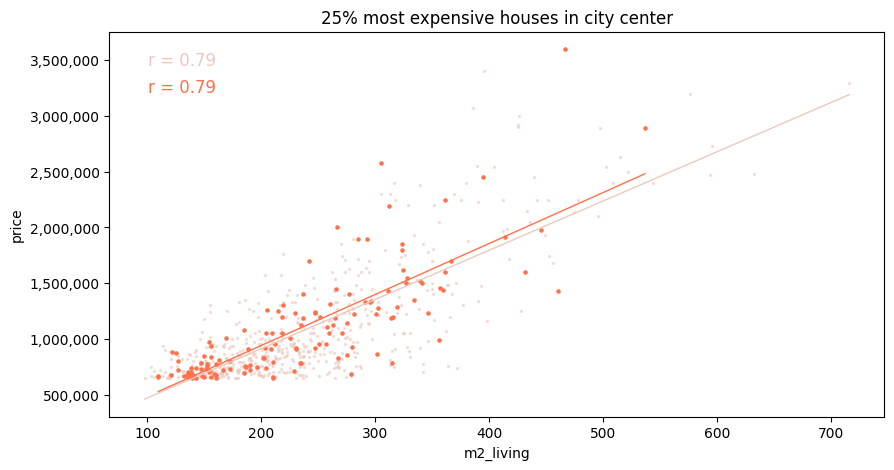

In [108]:
renovated_expensive_houses_in_center_area["m2_living"] = renovated_expensive_houses_in_center_area["sqft_living"] * 0.092903
expensive_houses_in_center_area["m2_living"] = expensive_houses_in_center_area["sqft_living"] * 0.092903

fig, ax = plt.subplots(figsize=(10, 5))
expensive_houses_in_center_area.plot(kind="scatter", x='m2_living', y='price', color=colors["beige"],alpha=0.5, s = 2,  ax=ax)
corr_houses_in_center_area = expensive_houses_in_center_area['m2_living'].corr(expensive_houses_in_center_area['price'])
ax.text(0.05, 0.95, f"r = {corr_houses_in_center_area:.2f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top', color=colors["beige"])

# Regressionslinie
x = expensive_houses_in_center_area['m2_living']
y = expensive_houses_in_center_area['price']
slope, intercept = np.polyfit(x, y, 1)

x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

ax.plot(x_fit, y_fit, color=colors["beige"], linewidth=1, label=f'Regression (r = {x.corr(y):.2f})')


renovated_expensive_houses_in_center_area.plot(kind="scatter", x='m2_living', y='price', color=colors["orange"],alpha=1, s = 5,  ax=ax)
corr_renovated = renovated_expensive_houses_in_center_area['m2_living'].corr(renovated_expensive_houses_in_center_area['price'])
ax.text(0.05, 0.88, f"r = {corr_renovated:.2f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top', color=colors["orange"])

# Regressionslinie
x = renovated_expensive_houses_in_center_area['m2_living']
y = renovated_expensive_houses_in_center_area['price']
slope, intercept = np.polyfit(x, y, 1)

x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

ax.plot(x_fit, y_fit, color=colors["orange"], linewidth=1, label=f'Regression (r = {x.corr(y):.2f})')
ax.set_title('25% most expensive houses in city center')



ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))
orange_circle = mlines.Line2D([], [], color=colors["orange"], marker='o', linestyle='None', markersize=8, label='renovated houses')

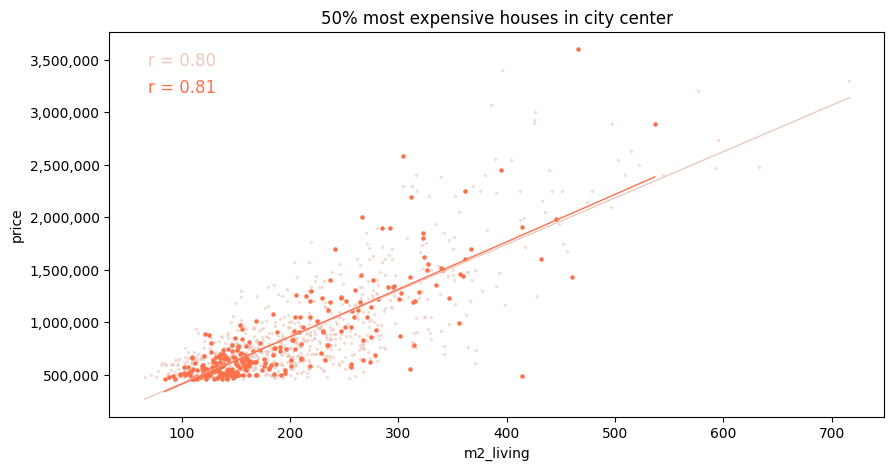

In [118]:
renovated_mid_expensive_houses_in_center_area["m2_living"] = renovated_mid_expensive_houses_in_center_area["sqft_living"] * 0.092903
mid_expensive_houses_in_center_area["m2_living"] = mid_expensive_houses_in_center_area["sqft_living"] * 0.092903

fig, ax = plt.subplots(figsize=(10, 5))
mid_expensive_houses_in_center_area.plot(kind="scatter", x='m2_living', y='price', color=colors["beige"],alpha=0.5, s = 2,  ax=ax)
corr_houses_in_center_area = mid_expensive_houses_in_center_area['m2_living'].corr(mid_expensive_houses_in_center_area['price'])
ax.text(0.05, 0.95, f"r = {corr_houses_in_center_area:.2f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top', color=colors["beige"])

# Regressionslinie
x = mid_expensive_houses_in_center_area['m2_living']
y = mid_expensive_houses_in_center_area['price']
slope, intercept = np.polyfit(x, y, 1)

x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

ax.plot(x_fit, y_fit, color=colors["beige"], linewidth=1, label=f'Regression (r = {x.corr(y):.2f})')


renovated_mid_expensive_houses_in_center_area.plot(kind="scatter", x='m2_living', y='price', color=colors["orange"],alpha=1, s = 5,  ax=ax)
corr_renovated = renovated_mid_expensive_houses_in_center_area['m2_living'].corr(renovated_mid_expensive_houses_in_center_area['price'])
ax.text(0.05, 0.88, f"r = {corr_renovated:.2f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top', color=colors["orange"])

# Regressionslinie
x = renovated_mid_expensive_houses_in_center_area['m2_living']
y = renovated_mid_expensive_houses_in_center_area['price']
slope, intercept = np.polyfit(x, y, 1)

x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

ax.plot(x_fit, y_fit, color=colors["orange"], linewidth=1, label=f'Regression (r = {x.corr(y):.2f})')
ax.set_title('50% most expensive houses in city center')



ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))
orange_circle = mlines.Line2D([], [], color=colors["orange"], marker='o', linestyle='None', markersize=8, label='renovated houses')

# TODO

- vielleicht noch was mit den ersten 3 graphen, das is biischen langweilig
- README
- diskussion, was bedeutet selbe regression, selbe correlation
- was geht ab bei 50% und renovierungen? man in die daten schauen
- 2 more thesen